# 2110010114  李佳琪

# 基于项目的协同过滤方法实现评分预测和Top-N推荐

Step 1: 加载库

In [5]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

Step 2: 下载并读取数据

In [8]:
# Read in data
ratings=pd.read_csv('D:\\大三上\\推荐系统\\第一次作业\\ml-25m\\ratings2.csv')

# Take a look at the data
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


ratings.csv有4列

In [9]:
# Get the dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048575 non-null  int64  
 1   movieId    1048575 non-null  int64  
 2   rating     1048575 non-null  float64
 3   timestamp  1048575 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 32.0 MB


In [10]:
# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

The ratings dataset has 7045 unique users
The ratings dataset has 22240 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


ratings dataset 有162541 个user；59047个movies；0.5-5，每0.5分一个rating，共10种分数

In [11]:
# Read in data
movies = pd.read_csv('D:\大三上\推荐系统\第一次作业\ml-25m\movies2.csv')

# Take a look at the data
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
# 将movieId作为matching key，Merge ratings and movies datasets
df = pd.merge(ratings, movies, on='movieId', how='inner')

# Take a look at the data
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


Step 3: EDA

过滤出ratings数量超过100的movies，并计算出平均得分

In [13]:
# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),number_of_ratings = ('rating', 'count')).reset_index()

# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]

# Check the information of the dataframe
agg_ratings_GT100.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2170 entries, 13 to 22225
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2170 non-null   object 
 1   mean_rating        2170 non-null   float64
 2   number_of_ratings  2170 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 67.8+ KB


In [14]:
# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
6897,Forrest Gump (1994),4.057987,3518
16632,"Shawshank Redemption, The (1994)",4.436067,3488
15023,Pulp Fiction (1994),4.182417,3418
16812,"Silence of the Lambs, The (1991)",4.131546,3227
12047,"Matrix, The (1999)",4.160738,3064


最受欢迎的电影 Forrest Gump，得到2518次评分

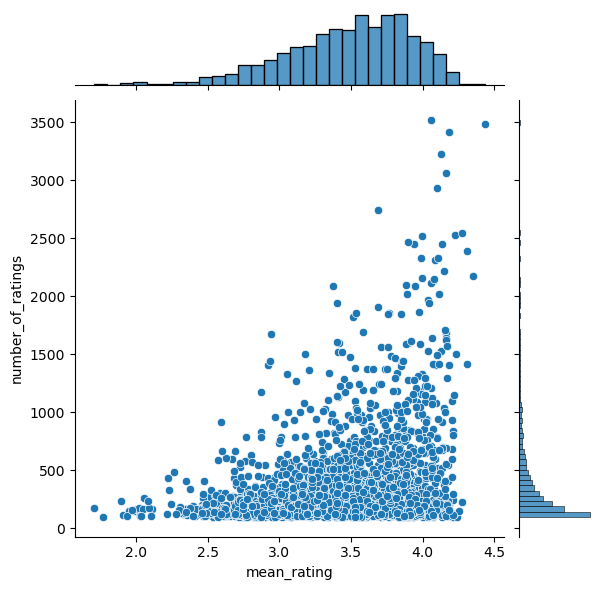

In [15]:
# visualization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [16]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827609 entries, 0 to 827608
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     827609 non-null  int64  
 1   movieId    827609 non-null  int64  
 2   rating     827609 non-null  float64
 3   timestamp  827609 non-null  int64  
 4   title      827609 non-null  object 
 5   genres     827609 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 44.2+ MB


In [17]:
# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', df_GT100['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))

The ratings dataset has 7044 unique users
The ratings dataset has 2172 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


Step 4: Create User-Movie Matrix

将数据集转化为矩阵，矩阵的行是电影名，列是用户。矩阵的数字表示user对movie的评分

In [18]:
# Create user-item matrix
subset_df = df_GT100.sample(n=5000)  # 选择较小的数据子集
matrix = subset_df.pivot_table(index='title', columns='userId', values='rating')
matrix.head()

userId,1,2,3,5,8,9,12,13,15,18,...,7016,7018,7023,7027,7028,7029,7030,7035,7036,7039
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(500) Days of Summer (2009),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 Things I Hate About You (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Step 5: Data Normalization

In [19]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 0)
matrix_norm.head()

userId,1,2,3,5,8,9,12,13,15,18,...,7016,7018,7023,7027,7028,7029,7030,7035,7036,7039
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(500) Days of Summer (2009),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 Things I Hate About You (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


低于电影平均评分的评分为负值，高于电影平均评分的评分为正值

Step 6: Calculate Similarity Score

In [20]:
# Item similarity matrix using Pearson correlation
item_similarity = matrix_norm.T.corr()
item_similarity.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),13 Going on 30 (2004),"13th Warrior, The (1999)",1408 (2007),...,You've Got Mail (1998),Young Frankenstein (1974),Young Guns II (1990),Young Sherlock Holmes (1985),Zero Dark Thirty (2012),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002)
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(500) Days of Summer (2009),NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 Things I Hate About You (1999),NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Item similarity matrix using cosine similarity
item_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
item_similarity_cosine

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Step 7: Predict User's Rating For One Movie
预测用户对电影的评分，以user1和movie American Pie为例：

1 创建user 1看过的以及评分过的电影，将user 1评分过的电影与A. P. 的相似度进行排序
2 user 1 观看并评分过的电影之与A P之间的相似度进行排序
3 选择相似度最高的top-N movies
4 计算预测的评分

In [22]:
# Pick a user ID
picked_userid = 1
# Pick a movie
picked_movie = 'American Pie (1999)'
# Movies that the target user has watched
picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={1:'rating'})
picked_userid_watched.head()

,title,rating
0,Ran (1985),0.0


user 1最喜欢的电影“Run (1985) ”

In [23]:
# Similarity score of the movie American Pie with all the other movies
picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={'American Pie (1999)':'similarity_score'})
# Rank the similarities between the movies user 1 rated and American Pie.
n = 5
picked_userid_watched_similarity = pd.merge(left=picked_userid_watched, 
                                            right=picked_movie_similarity_score, 
                                            on='title', 
                                            how='inner')\
                                     .sort_values('similarity_score', ascending=False)[:5]
# Take a look at the User 1 watched movies with highest similarity
picked_userid_watched_similarity

,title,rating,similarity_score
0,Ran (1985),0.0,NaN


After that, calculate the weighted average of ratings and similarities scores, so the movies with higher similarity scores get more weight. This weighted average is the predicted rating for American Pie by user 1.

计算带权重的分数和相似度的得分

In [24]:
# Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1
predicted_rating = round(np.average(picked_userid_watched_similarity['rating'], 
                                    weights=picked_userid_watched_similarity['similarity_score']), 6)
print(f'The predicted rating for {picked_movie} by user {picked_userid} is {predicted_rating}' )

The predicted rating for American Pie (1999) by user 1 is nan


Step 8: Movie Recommendation
创建一个item-item电影推荐系统：

创建一个目标用户以前没有看过的电影列表
Loop未观看的电影并为每部电影创建预测分数
将未观看电影的预测分数从高到低排列
选择前k部电影作为目标用户的推荐

In [25]:
# Item-based recommendation function
def item_based_rec(picked_userid=1, number_of_similar_items=5, number_of_recommendations =3):
  import operator
  # Movies that the target user has not watched
  picked_userid_unwatched = pd.DataFrame(matrix_norm[picked_userid].isna()).reset_index()
  picked_userid_unwatched = picked_userid_unwatched[picked_userid_unwatched[1]==True]['title'].values.tolist()
  # Movies that the target user has watched
  picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                            .sort_values(ascending=False))\
                            .reset_index()\
                            .rename(columns={1:'rating'})
  
  # Dictionary to save the unwatched movie and predicted rating pair
  rating_prediction ={}  
  # Loop through unwatched movies          
  for picked_movie in picked_userid_unwatched: 
    # Calculate the similarity score of the picked movie iwth other movies
    picked_movie_similarity_score = item_similarity[[picked_movie]].reset_index().rename(columns={picked_movie:'similarity_score'})
    # Rank the similarities between the picked user watched movie and the picked unwatched movie.
    picked_userid_watched_similarity = pd.merge(left=picked_userid_watched, 
                                                right=picked_movie_similarity_score, 
                                                on='title', 
                                                how='inner')\
                                        .sort_values('similarity_score', ascending=False)[:number_of_similar_items]
    # Calculate the predicted rating using weighted average of similarity scores and the ratings from user 1
    predicted_rating = round(np.average(picked_userid_watched_similarity['rating'], 
                                        weights=picked_userid_watched_similarity['similarity_score']), 6)
    # Save the predicted rating in the dictionary
    rating_prediction[picked_movie] = predicted_rating
    # Return the top recommended movies
  return sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_recommendations]
# Get recommendations
recommended_movie = item_based_rec(picked_userid=1, number_of_similar_items=5, number_of_recommendations =3)
recommended_movie

[("'burbs, The (1989)", nan),
 ('(500) Days of Summer (2009)', nan),
 ('10 Things I Hate About You (1999)', nan)]

# 基于用户的协同过滤方法实现评分预测和Top-N推荐

加载库

In [26]:
# 数据处理
import pandas as pd
import numpy as np
import scipy.stats

# 可视化
import seaborn as sns

# 相似度
from sklearn.metrics.pairwise import cosine_similarity

读取数据

In [27]:
# 读取数据
ratings=pd.read_csv('D:\\大三上\\推荐系统\\第一次作业\\ml-25m\\ratings2.csv')

# 查看数据
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [28]:
# 查看dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048575 non-null  int64  
 1   movieId    1048575 non-null  int64  
 2   rating     1048575 non-null  float64
 3   timestamp  1048575 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 32.0 MB


In [29]:
# users数量
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')

# movies数量
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')

# ratings数量
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

# ratings取值
print('The unique ratings are', sorted(ratings['rating'].unique()))

The ratings dataset has 7045 unique users
The ratings dataset has 22240 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [30]:
# 读取movies.csv
movies = pd.read_csv('D:\\大三上\\推荐系统\\第一次作业\\ml-25m\\movies2.csv')

# 查看数据
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [31]:
# Merge ratings and movies datasets
df = pd.merge(ratings, movies, on='movieId', how='inner')

# 查看数据
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,3,296,5.0,1439474476,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,4,296,4.0,1573938898,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,5,296,4.0,830786155,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4,7,296,4.0,835444730,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


In [32]:
# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# 保留评分数量超过100个的电影
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2170 entries, 13 to 22225
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2170 non-null   object 
 1   mean_rating        2170 non-null   float64
 2   number_of_ratings  2170 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 67.8+ KB


In [33]:
# 查找最受欢迎的电影
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
6897,Forrest Gump (1994),4.057987,3518
16632,"Shawshank Redemption, The (1994)",4.436067,3488
15023,Pulp Fiction (1994),4.182417,3418
16812,"Silence of the Lambs, The (1991)",4.131546,3227
12047,"Matrix, The (1999)",4.160738,3064


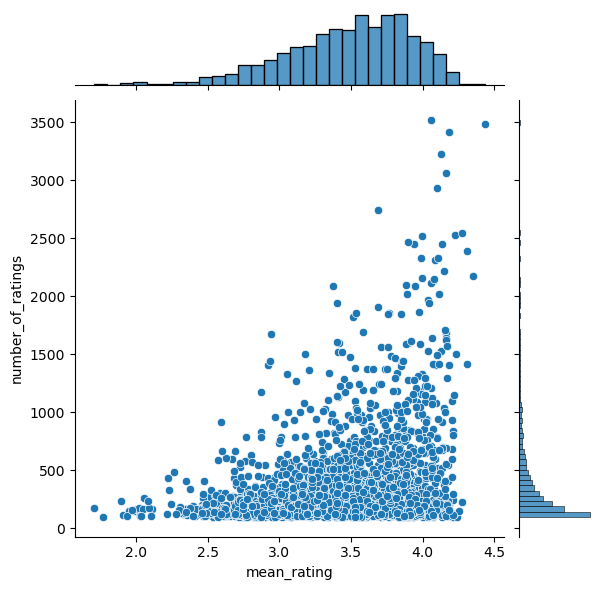

In [34]:
# 可视化
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [35]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827609 entries, 0 to 827608
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     827609 non-null  int64  
 1   movieId    827609 non-null  int64  
 2   rating     827609 non-null  float64
 3   timestamp  827609 non-null  int64  
 4   title      827609 non-null  object 
 5   genres     827609 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 44.2+ MB


In [36]:
# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', df_GT100['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))

The ratings dataset has 7044 unique users
The ratings dataset has 2172 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [37]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='userId', columns='title', values='rating')
matrix.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Young Sherlock Holmes (1985),Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),隆Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,3.5,NaN,NaN,3.5,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,4.5,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# 标准化user-item矩阵
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Young Sherlock Holmes (1985),Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),隆Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.240367,-0.259633,NaN,NaN,-0.259633,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.558824,1.058824,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# 用户的Pearson相似度
user_similarity = matrix_norm.T.corr()
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,7036,7037,7038,7039,7040,7041,7042,7043,7044,7045
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.522233,0.355012,0.236525,NaN,NaN,-1.000000,1.000000,NaN,NaN,...,0.280420,NaN,-0.333333,-0.124354,NaN,0.085749,NaN,NaN,NaN,-0.539360
2,-0.522233,1.000000,0.429799,0.188955,0.350768,0.341565,0.000000,-0.097308,-0.076780,0.652493,...,-0.002877,0.314134,-0.184537,0.051489,-0.115431,0.025844,0.447408,0.251399,-0.020901,0.219700
3,0.355012,0.429799,1.000000,0.315297,0.435520,-0.099258,-0.500000,0.273991,-0.493181,0.284511,...,0.222853,0.500771,0.232519,0.279448,0.217173,0.213094,0.517630,0.280000,0.143789,0.310457
4,0.236525,0.188955,0.315297,1.000000,0.009440,-0.790569,NaN,0.499261,-0.318235,0.626348,...,0.252818,-0.642857,0.199902,0.031110,0.939286,0.235227,0.102062,NaN,0.791448,-0.086628
5,NaN,0.350768,0.435520,0.009440,1.000000,0.166667,0.243332,0.124686,0.483738,0.637036,...,0.394230,1.000000,0.942809,0.247814,0.300501,-0.083286,0.355722,0.538587,0.287543,0.341790


In [40]:
# 用户的余弦相似度
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

array([[ 1.00000000e+00, -5.48808714e-03,  4.34911974e-02, ...,
         5.96530960e-02,  2.17696611e-04, -4.63511287e-03],
       [-5.48808714e-03,  1.00000000e+00,  7.43933068e-02, ...,
         1.61849855e-02, -2.47618187e-04,  8.51685754e-02],
       [ 4.34911974e-02,  7.43933068e-02,  1.00000000e+00, ...,
         2.52532141e-02,  9.26032834e-03,  4.81264630e-02],
       ...,
       [ 5.96530960e-02,  1.61849855e-02,  2.52532141e-02, ...,
         1.00000000e+00,  4.83584975e-02,  8.39447482e-02],
       [ 2.17696611e-04, -2.47618187e-04,  9.26032834e-03, ...,
         4.83584975e-02,  1.00000000e+00,  1.04882322e-02],
       [-4.63511287e-03,  8.51685754e-02,  4.81264630e-02, ...,
         8.39447482e-02,  1.04882322e-02,  1.00000000e+00]])

In [41]:
# Pick a user ID
picked_userid = 1
# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)
# Take a look at the data
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,7036,7037,7038,7039,7040,7041,7042,7043,7044,7045
userId,,,,,,,,,,,,,,,,,,,,,
2,-0.522233,1.000000,0.429799,0.188955,0.350768,0.341565,0.000000,-0.097308,-0.076780,0.652493,...,-0.002877,0.314134,-0.184537,0.051489,-0.115431,2.584413e-02,0.447408,0.251399,-0.020901,0.219700
3,0.355012,0.429799,1.000000,0.315297,0.435520,-0.099258,-0.500000,0.273991,-0.493181,0.284511,...,0.222853,0.500771,0.232519,0.279448,0.217173,2.130940e-01,0.517630,0.280000,0.143789,0.310457
4,0.236525,0.188955,0.315297,1.000000,0.009440,-0.790569,NaN,0.499261,-0.318235,0.626348,...,0.252818,-0.642857,0.199902,0.031110,0.939286,2.352268e-01,0.102062,NaN,0.791448,-0.086628
5,NaN,0.350768,0.435520,0.009440,1.000000,0.166667,0.243332,0.124686,0.483738,0.637036,...,0.394230,1.000000,0.942809,0.247814,0.300501,-8.328555e-02,0.355722,0.538587,0.287543,0.341790
6,NaN,0.341565,-0.099258,-0.790569,0.166667,1.000000,1.000000,-0.556038,-0.250000,0.000000,...,0.052129,0.475093,-1.000000,-0.065795,-0.806226,3.447964e-18,0.000000,1.000000,NaN,0.533468


In [42]:
# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 1 are userId
7011    1.0
4058    1.0
3563    1.0
1380    1.0
5579    1.0
5582    1.0
5606    1.0
1452    1.0
3949    1.0
3943    1.0
Name: 1, dtype: float64


In [43]:
# Movies that the target user has watched
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

title,"Amelie (Fabuleux destin d'Am茅lie Poulain, Le) (2001)",Back to the Future Part II (1989),Back to the Future Part III (1990),"Bridge on the River Kwai, The (1957)",City of God (Cidade de Deus) (2002),Delicatessen (1991),Dirty Dancing (1987),Eternal Sunshine of the Spotless Mind (2004),Finding Nemo (2003),Gattaca (1997),...,Pulp Fiction (1994),Ran (1985),Requiem for a Dream (2000),Run Lola Run (Lola rennt) (1998),"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Shrek 2 (2004),Singin' in the Rain (1952),Talk to Her (Hable con Ella) (2002),Three Colors: Blue (Trois couleurs: Bleu) (1993),Three Colors: Red (Trois couleurs: Rouge) (1994)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.548387,-1.451613,-1.451613,0.048387,1.048387,-0.451613,0.048387,1.048387,0.048387,0.048387,...,1.048387,-0.451613,1.048387,1.048387,1.048387,0.048387,-0.451613,0.048387,1.048387,-0.451613


In [44]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

title,"'burbs, The (1989)",(500) Days of Summer (2009),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),...,When Harry Met Sally... (1989),Whiplash (2014),Who Framed Roger Rabbit? (1988),Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)",Wolf (1994),"X-Files: Fight the Future, The (1998)",Yes Man (2008),Young Frankenstein (1974),Young Guns II (1990)
userId,,,,,,,,,,,,,,,,,,,,,
1380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.072464,NaN,NaN,NaN,NaN,NaN,NaN
3563,NaN,NaN,-0.781250,NaN,NaN,NaN,0.21875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.21875,NaN,NaN,NaN,NaN,NaN
3943,NaN,NaN,NaN,NaN,1.246753,NaN,NaN,0.246753,-0.753247,NaN,...,NaN,NaN,0.246753,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5579,NaN,NaN,1.052632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5582,NaN,0.179245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.320755,NaN,NaN
5606,NaN,NaN,NaN,-0.929577,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.929577,NaN,NaN,1.070423,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_movies

title,"'burbs, The (1989)",(500) Days of Summer (2009),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),...,When Harry Met Sally... (1989),Whiplash (2014),Who Framed Roger Rabbit? (1988),Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)",Wolf (1994),"X-Files: Fight the Future, The (1998)",Yes Man (2008),Young Frankenstein (1974),Young Guns II (1990)
userId,,,,,,,,,,,,,,,,,,,,,
1380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.072464,NaN,NaN,NaN,NaN,NaN,NaN
3563,NaN,NaN,-0.781250,NaN,NaN,NaN,0.21875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.21875,NaN,NaN,NaN,NaN,NaN
3943,NaN,NaN,NaN,NaN,1.246753,NaN,NaN,0.246753,-0.753247,NaN,...,NaN,NaN,0.246753,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5579,NaN,NaN,1.052632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5582,NaN,0.179245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.320755,NaN,NaN
5606,NaN,NaN,NaN,-0.929577,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.929577,NaN,NaN,1.070423,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score为用户相似度与movie评分乘积的累计加和
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # 得到item的平均score
  item_score[i] = total / count

# 将dictionary转换为pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])
    
# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Select top m movies
m = 10
ranked_item_score.head(m)

,movie,movie_score
57,Ben-Hur (1959),1.246753
4,12 Angry Men (1957),1.246753
125,Cool Hand Luke (1967),1.246753
39,Austin Powers: International Man of Mystery (1...,1.246753
35,Army of Darkness (1993),1.246753
12,"Adventures of Priscilla, Queen of the Desert, ...",1.246753
107,Chinatown (1974),1.218750
384,Shine (1996),1.218750
158,"English Patient, The (1996)",1.218750
451,Wallace & Gromit: A Close Shave (1995),1.087145


In [47]:
# Average rating for the picked user
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]

# Print the average movie rating for user 1
print(f'The average movie rating for user {picked_userid} is {avg_rating:.2f}')

The average movie rating for user 1 is 3.95


In [48]:
# Calcuate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating

# Take a look at the data
ranked_item_score.head(m)

,movie,movie_score,predicted_rating
57,Ben-Hur (1959),1.246753,5.198366
4,12 Angry Men (1957),1.246753,5.198366
125,Cool Hand Luke (1967),1.246753,5.198366
39,Austin Powers: International Man of Mystery (1...,1.246753,5.198366
35,Army of Darkness (1993),1.246753,5.198366
12,"Adventures of Priscilla, Queen of the Desert, ...",1.246753,5.198366
107,Chinatown (1974),1.218750,5.170363
384,Shine (1996),1.218750,5.170363
158,"English Patient, The (1996)",1.218750,5.170363
451,Wallace & Gromit: A Close Shave (1995),1.087145,5.038758
